In [1]:
# install the required libraries, uncomment the following lines if you are running this notebook for the first time
# !pip3 -q install numpy
# !pip3 -q install pandas
# !pip3 -q install xgboost
# !pip3 -q install graphviz
# !pip3 -q install matplotlib
# !pip3 -q install scikit-learn

# importing the required libraries
import numpy as np
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# load the dataset
raw_df = pd.read_csv('all_4_grades_updated.csv')
raw_df = raw_df.set_index('product_name')

# columns to be used as features
features = ['energy-kj_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g', 'fruit_vege_nut_100g']

# columns that can be used as labels
label_nsg = ['nutriscore_grade']
label_fnsg = ['fit_nutri_grade']
label_oet5g = ['opt_el_tri_50_grade']
label_pet5g = ['pes_el_tri_50_grade']

#  change label to get results for different grades
# label = label_nsg
# label = label_fnsg
label = label_oet5g
# label = label_pet5g

In [3]:
# make a dataframe with only the features and label
raw_df = raw_df[features + label]
raw_df = raw_df.replace(['a','b','c','d','e'], [0,1,2,3,4])

# create separate dataframes for features and label
X = raw_df[features]
y = raw_df[label]

In [4]:
# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10, stratify=y)

In [5]:
X_train.count()[0], X_test.count()[0]

(232, 78)

# Decision Tree

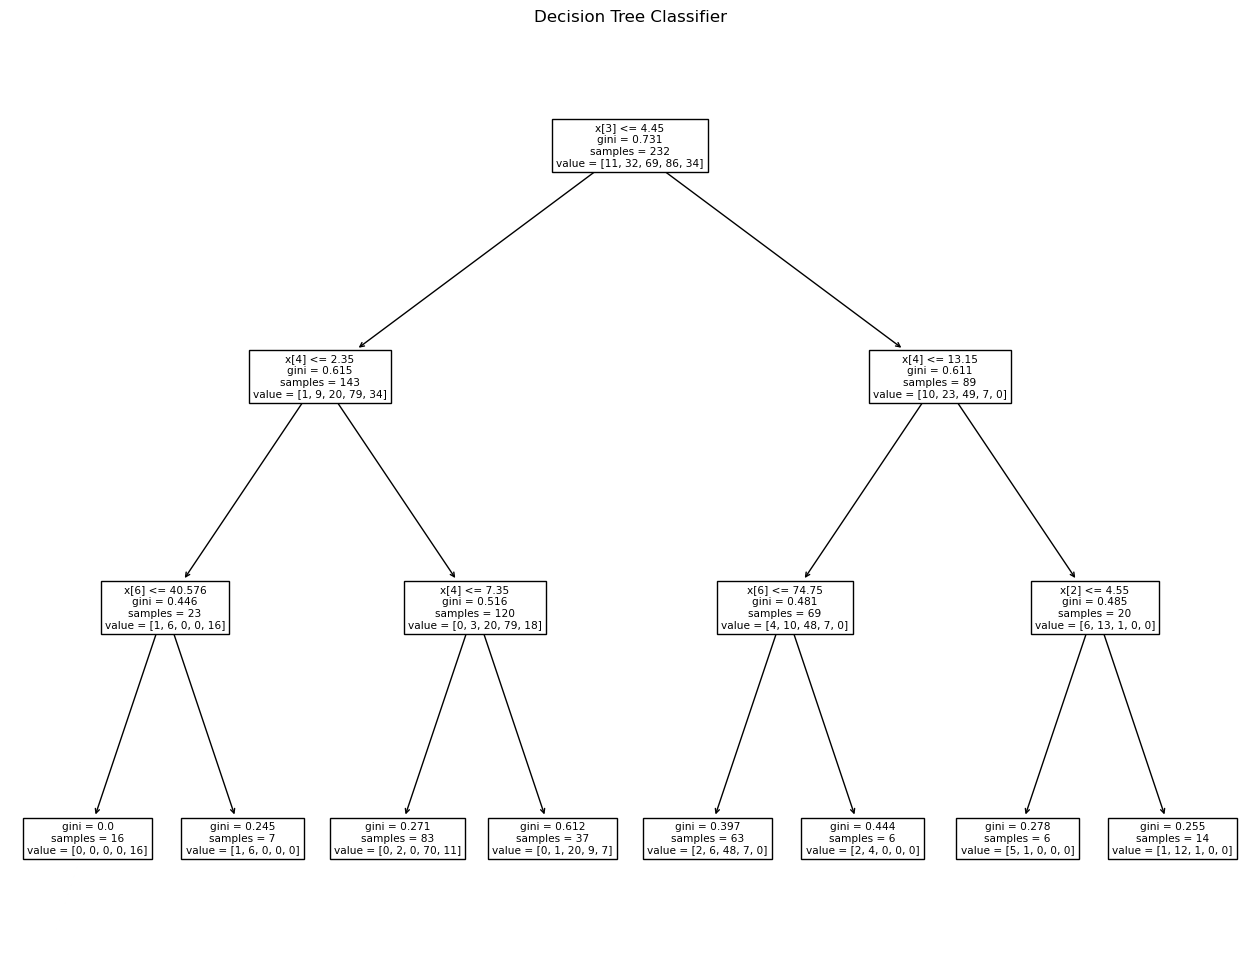

In [6]:
# create a decision tree classifier
clf = tree.DecisionTreeClassifier(random_state=10, max_depth=3)
clf = clf.fit(X_train, y_train)
y_score = clf.predict_proba(X_test)

plt.rcParams["figure.figsize"] = [16, 12]
tree.plot_tree(clf)
plt.title('Decision Tree Classifier')
plt.savefig("plots/" +label[0]+ "/decision_tree_classifier.png")
plt.show()

In [7]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape

(78, 5)

In [8]:
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

n_classes = 5
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.92
Macro-averaged One-vs-Rest ROC AUC score:
0.91


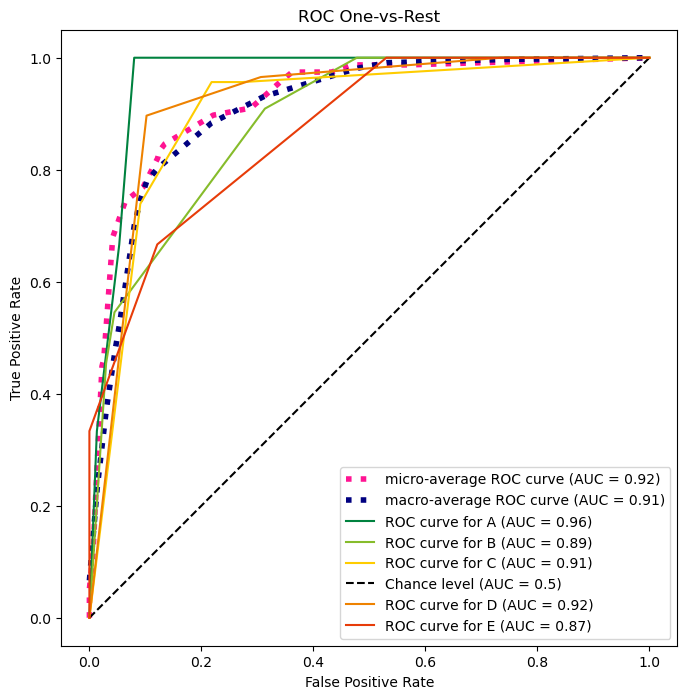

In [9]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(8, 8))
target_names = ["A", "B", "C", "D", "E"]

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

grade_palette = {
    "a": "#00823F",
    "b": "#86BC2B",
    "c": "#FECC00",
    "d": "#EE8200",
    "e": "#E73C09",
}
for class_id, color in zip(range(n_classes), list(grade_palette.values())):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
        plot_chance_level=(class_id == 2),
    )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC One-vs-Rest")
plt.legend()
plt.savefig("plots/" +label[0]+ "/decision_tree_roc.png")
plt.show()

0.7435897435897436


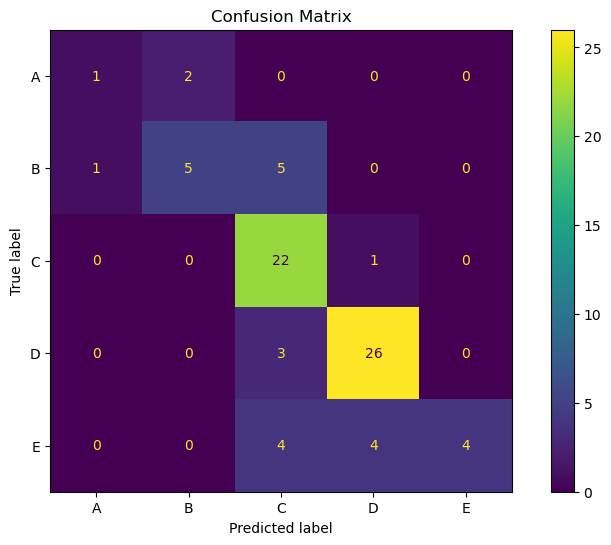

In [10]:
print(clf.score(X_test,y_test))
plt.rcParams["figure.figsize"] = [10, 6]
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
ConfusionMatrixDisplay(cm, display_labels=['A','B','C','D','E']).plot()
plt.title("Confusion Matrix")
plt.savefig("plots/" +label[0]+ "/decision_tree_confusion_matrix.png")
plt.show()

# Random Forest

In [11]:
clf = RandomForestClassifier(random_state=10)
clf.fit(X_train, y_train)
y_score = clf.predict_proba(X_test)

/Users/rizwan/anaconda3/envs/albu/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [12]:
clf.score(X_test,y_test)

0.8076923076923077

In [13]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape

(78, 5)

In [14]:
from sklearn.metrics import auc, roc_curve

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

n_classes = 5
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.97
Macro-averaged One-vs-Rest ROC AUC score:
0.97


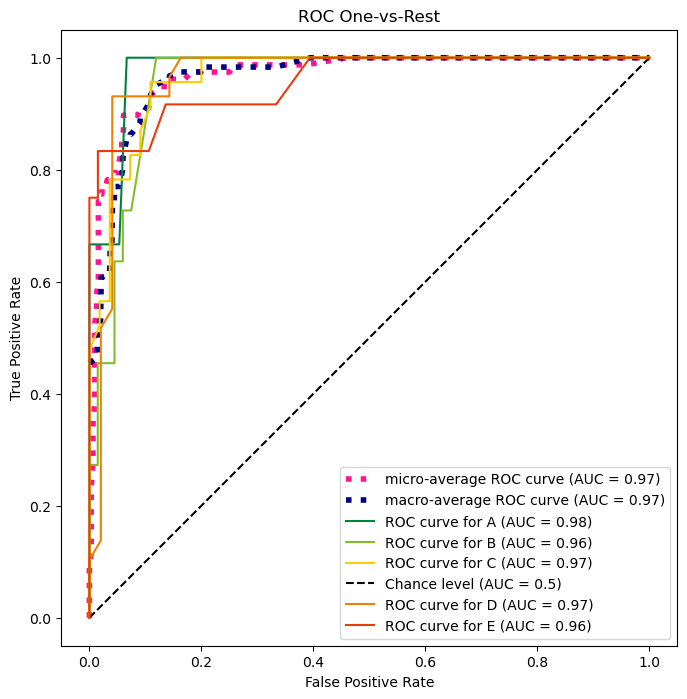

In [15]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(8, 8))
target_names = ["A", "B", "C", "D", "E"]

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

grade_palette = {
    "a": "#00823F",
    "b": "#86BC2B",
    "c": "#FECC00",
    "d": "#EE8200",
    "e": "#E73C09",
}
for class_id, color in zip(range(n_classes), list(grade_palette.values())):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
        plot_chance_level=(class_id == 2),
    )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC One-vs-Rest")
plt.legend()
plt.savefig("plots/" +label[0]+ "/random_forest_roc.png")
plt.show()

0.8076923076923077


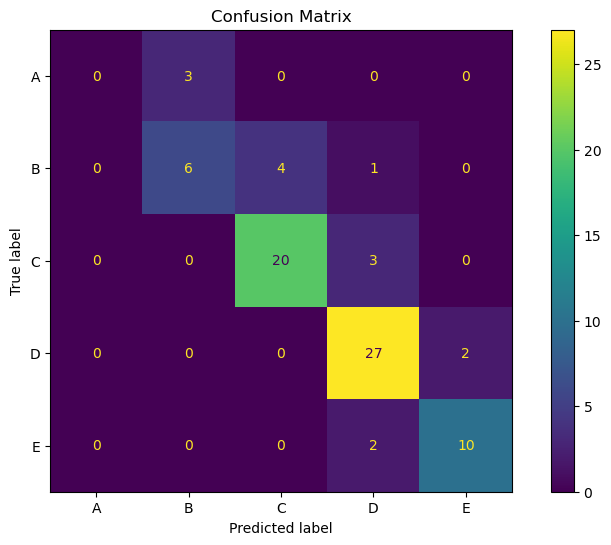

In [16]:
print(clf.score(X_test,y_test))
plt.rcParams["figure.figsize"] = [10, 6]
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
ConfusionMatrixDisplay(cm, display_labels=['A','B','C','D','E']).plot()
plt.title("Confusion Matrix")
plt.savefig("plots/" +label[0]+ "/random_forest_confusion_matrix.png")
plt.show()

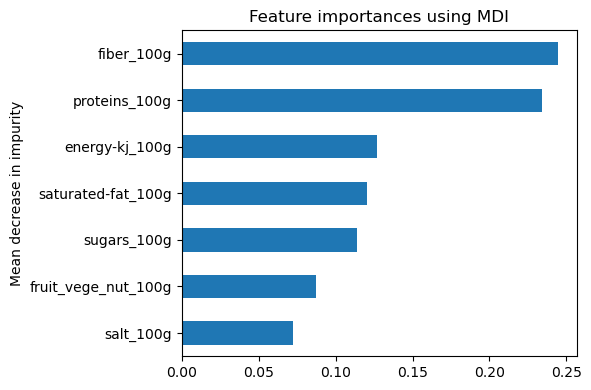

In [17]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
feature_names = [x for x in X_test]

forest_importances = pd.Series(importances, index=feature_names)

plt.rcParams["figure.figsize"] = [6, 4]
fig, ax = plt.subplots()
forest_importances.sort_values(ascending=True).plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
fig.savefig("plots/" +label[0]+ "/random_forest_feature_importance.png")